In [ ]:
# Hello there.   This is a do-over of the floating preferred analyzer

# Time to develop clean modules. Let's start with reading in a list of prefs
# The input data consists of three separate tables:
# a) A listing of tickers and their configurations
# b) A list of ratings for each company (equivalently, of the ticker)
# c) The current interest rate environment, which has only the 3-month rate and the prime rate



In [31]:
# Imports go here
import pandas as pd
import requests_cache
# local ones
import prefcode as pc


In [260]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Set up cache
session_cached = requests_cache.CachedSession('yfinance.cache',expire_after=3600)
session_uncached = requests_cache.CachedSession('yfinance2.cache',expire_after=30)


In [34]:
# Read the prefs database

print("Setting up databases")
df, interest_db = pc.setup_databases(preffile='./fixed.csv')


Setting up databases


In [75]:
print("Fetching price data")
pc.fetch_prices(df, session_cached, fetch=False)
df.drop(columns='Maturity Date', inplace=True, errors='ignore')

Fetching price data


In [76]:
df = pc.add_company_ticker_to_frame(df)


In [77]:
print("Updating dividends and current yield")
df = pc.update_div_and_yield(df, interest_db,price_column="Price",type='fixed')
df.sort_values(by='CurYieldPct', ascending=True)

Updating dividends and current yield


,Ticker,Div,Spread,Reset Date,Price,Rating,Company,CurYieldPct
129,SLF.PR.G,0.46,141,2025-06-30,16.99,P2H,SLF,2.7075
122,PWF.PR.P,0.50,160,2026-01-31,17.21,P2H,PWF,2.9053
91,FTS.PR.H,0.46,145,2025-06-01,15.65,P3H,FTS,2.9393
130,SLF.PR.H,0.71,217,2021-09-30,23.46,P2H,SLF,3.0264
143,TRP.PR.B,0.42,128,2025-06-30,13.38,P2L,TRP,3.1390
...,...,...,...,...,...,...,...,...
77,ENB.PR.H,1.09,212,2023-09-01,17.25,P3H,ENB,6.3188
62,ECN.PR.A,1.63,544,2021-12-31,25.54,P3L,ECN,6.3821
0,AIM.PR.A,1.20,375,2025-03-31,18.30,ZR,AIM,6.5574
1,AIM.PR.C,1.50,420,2024-03-01,21.20,ZR,AIM,7.0755


In [78]:
print("Updating market spread for later calculation")
#df.drop(columns='Type', inplace=True, errors='ignore')
# Drop the NVCC items
mdf = df[~df['Rating'].isin(['P2Hn','P2Ln','P3In'])].copy()

mdf = pc.update_market_spread(mdf, interest_db, preftype='fixed')
mdf.drop(columns=['Type'], inplace=True, errors='ignore')
mdf.sort_values(by=['Rating','CurYieldPct'],ascending=True)


Updating market spread for later calculation


,Ticker,Div,Spread,Reset Date,Price,Rating,Company,CurYieldPct,MSpread
129,SLF.PR.G,0.46,141,2025-06-30,16.99,P2H,SLF,2.7075,1.8845
122,PWF.PR.P,0.50,160,2026-01-31,17.21,P2H,PWF,2.9053,2.0823
130,SLF.PR.H,0.71,217,2021-09-30,23.46,P2H,SLF,3.0264,2.2034
46,CIU.PR.C,0.57,136,2026-06-01,15.35,P2H,CIU,3.7134,2.8904
131,SLF.PR.I,0.95,273,2021-12-31,25.35,P2H,SLF,3.7475,2.9245
...,...,...,...,...,...,...,...,...,...
1,AIM.PR.C,1.50,420,2024-03-01,21.20,ZR,AIM,7.0755,6.2525
28,BIR.PR.A,2.09,683,2022-09-30,26.00,zNR,BIR,8.0385,7.2155
25,BIP.PR.A,0.99,356,2025-06-30,26.00,None,BIP,3.8077,2.9847
27,BIP.PR.C,1.34,464,2021-09-30,25.34,None,BIP,5.2881,4.4651


In [78]:
#pc.calculate_avg_per_rating(df,column='MSpread')

,mean,count
,MSpread,MSpread
Rating,,
P2H,2.740613,8
P2I,3.297475,12
P2L,3.619404,26
P3H,4.188224,41
P3I,4.324369,13
P3L,4.392153,15
P4H,4.221933,3
P6,4.989500,1


In [80]:
#foo = pc.calculate_avg_bucket_per_column(mdf,bucket='Company', column='MSpread')

In [81]:
mdf['CMSpread'] = mdf.groupby('Company')['MSpread'].transform('mean')

In [82]:
mdf['DeltaCM'] = [ round(x-cm,3) for (x,cm) in zip(mdf['MSpread'], mdf['CMSpread'])]

In [83]:
mdf['AbsDelta']= [ abs(x)  for x in  mdf['DeltaCM']]
mdf.sort_values(by='AbsDelta', ascending=False).head(5)

,Ticker,Div,Spread,Reset Date,Price,Rating,Company,CurYieldPct,MSpread,CMSpread,DeltaCM,AbsDelta
91,FTS.PR.H,0.46,145,2025-06-01,15.65,P3H,FTS,2.9393,2.1163,3.497700,-1.381,1.381
72,ENB.PF.G,0.75,268,2024-09-01,17.66,P3H,ENB,4.2469,3.4239,4.693907,-1.270,1.270
71,ENB.PF.E,0.76,266,2025-06-01,17.60,P3H,ENB,4.3182,3.4952,4.693907,-1.199,1.199
25,BIP.PR.A,0.99,356,2025-06-30,26.00,None,BIP,3.8077,2.9847,4.006500,-1.022,1.022
66,EMA.PR.A,0.55,184,2025-08-15,16.90,P3H,EMA,3.2544,2.4314,3.400433,-0.969,0.969


In [84]:
mdf[mdf['Company'] == 'ENB'].sort_values(by='CurYieldPct', ascending=False)

,Ticker,Div,Spread,Reset Date,Price,Rating,Company,CurYieldPct,MSpread,CMSpread,DeltaCM,AbsDelta
77,ENB.PR.H,1.09,212,2023-09-01,17.25,P3H,ENB,6.3188,5.4958,4.693907,0.802,0.802
76,ENB.PR.F,1.17,251,2023-06-01,18.73,P3H,ENB,6.2467,5.4237,4.693907,0.730,0.730
75,ENB.PR.D,1.12,237,2023-03-01,18.00,P3H,ENB,6.2222,5.3992,4.693907,0.705,0.705
80,ENB.PR.P,1.10,250,2024-03-01,18.33,P3H,ENB,6.0011,5.1781,4.693907,0.484,0.484
78,ENB.PR.J,1.12,257,2024-03-01,18.84,P3H,ENB,5.9448,5.1218,4.693907,0.428,0.428
74,ENB.PR.B,1.00,240,2022-06-15,17.07,P3H,ENB,5.8582,5.0352,4.693907,0.341,0.341
69,ENB.PF.A,1.10,266,2024-12-01,19.02,P3H,ENB,5.7834,4.9604,4.693907,0.266,0.266
81,ENB.PR.T,1.02,250,2024-06-01,18.10,P3H,ENB,5.6354,4.8124,4.693907,0.118,0.118
82,ENB.PR.Y,0.93,238,2024-09-01,17.27,P3H,ENB,5.3851,4.5621,4.693907,-0.132,0.132
70,ENB.PF.C,0.99,264,2025-03-01,18.65,P3H,ENB,5.3083,4.4853,4.693907,-0.209,0.209


In [86]:
mdf[mdf['Company'] == 'ENB'].sort_values(by='Reset Date', ascending=False)

,Ticker,Div,Spread,Reset Date,Price,Rating,Company,CurYieldPct,MSpread,CMSpread,DeltaCM,AbsDelta
71,ENB.PF.E,0.76,266,2025-06-01,17.60,P3H,ENB,4.3182,3.4952,4.693907,-1.199,1.199
70,ENB.PF.C,0.99,264,2025-03-01,18.65,P3H,ENB,5.3083,4.4853,4.693907,-0.209,0.209
69,ENB.PF.A,1.10,266,2024-12-01,19.02,P3H,ENB,5.7834,4.9604,4.693907,0.266,0.266
72,ENB.PF.G,0.75,268,2024-09-01,17.66,P3H,ENB,4.2469,3.4239,4.693907,-1.270,1.270
82,ENB.PR.Y,0.93,238,2024-09-01,17.27,P3H,ENB,5.3851,4.5621,4.693907,-0.132,0.132
81,ENB.PR.T,1.02,250,2024-06-01,18.10,P3H,ENB,5.6354,4.8124,4.693907,0.118,0.118
78,ENB.PR.J,1.12,257,2024-03-01,18.84,P3H,ENB,5.9448,5.1218,4.693907,0.428,0.428
80,ENB.PR.P,1.10,250,2024-03-01,18.33,P3H,ENB,6.0011,5.1781,4.693907,0.484,0.484
79,ENB.PR.N,1.00,265,2023-12-01,20.17,P3H,ENB,4.9579,4.1349,4.693907,-0.559,0.559
77,ENB.PR.H,1.09,212,2023-09-01,17.25,P3H,ENB,6.3188,5.4958,4.693907,0.802,0.802


In [88]:
enb = mdf[mdf['Company'] == 'ENB'].copy()


In [109]:
import matplotlib.pyplot as plt

plt.close("all")

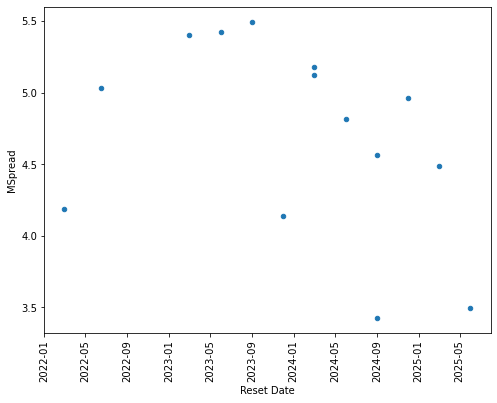

In [108]:
#plt.figure(figsize=(10,6))
#enb.set_index('Reset Date')
#ax =enb.plot.scatter(x="Reset Date", y="MSpread",figsize=(8,6),rot=90)
#df[['Reset Date','MSpread','Ticker']].apply(lambda x: ax.text(*x),axis=1)
#plt.show()


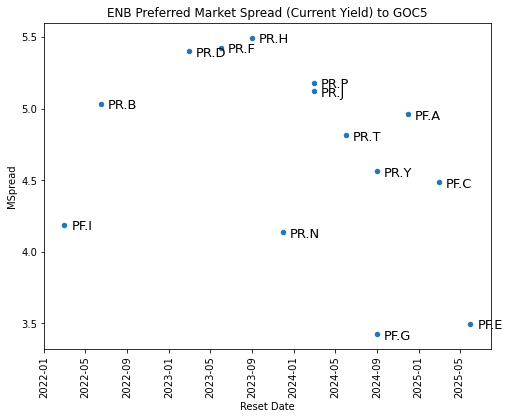

In [132]:
enb.set_index('Ticker')
fig,ax=plt.subplots()
enb.plot('Reset Date','MSpread',kind='scatter',figsize=(8,6),rot=90,ax=ax, 
         title='ENB Preferred Market Spread (Current Yield) to GOC5')
for k,v in enb.iterrows():
    #print(v['Reset Date'])
    ax.annotate(v['Ticker'][4:],(v['Reset Date'], v['MSpread']),
               xytext=(7,-5),
               textcoords='offset points',
               fontsize=13)

In [150]:
import resets as rs
import datetime as dt
import prefutils as pu
import resets as rs

In [212]:
# Test the basic function
# ENB.PF.A
buy_date = dt.datetime.today()
curdiv = 1.02425
future_div = 25 * (.87+2.66)/100
curprice = 19.1
reset_date = dt.datetime(2024,12,1)
month_cycle = rs.month_cycle_from_start_month("F")
maturity_date = dt.datetime(2055,12,1)
foo = rs.compute_ytm_basic(buy_date, curprice, curdiv, reset_date, future_div,
                           curprice, maturity_date, month_cycle, verbose=False)

print(foo)
# This is a bit high compared to Hymas

0.04918136645374363


In [222]:
def compute_ytm_basic_futurediv(curprice, curdiv, spread, reset_date, goc5,
                            monthcode, par=25):
                            
    month_cycle = rs.month_cycle_from_start_month(monthcode)
    future_div = par * (goc5 + spread/100)/100
    buy_date = buy_date = dt.datetime.today()
    maturity_date = dt.datetime(2055,12,1)
    
    return rs.compute_ytm_basic(buy_date, curprice, curdiv, reset_date, future_div,
                           curprice, maturity_date, month_cycle)
    

def ytm_basic_df(df, goc5=0.87, par=25, monthcode="F"):
    
    df['YTM'] = [ compute_ytm_basic_futurediv(curprice, curdiv, spread, reset_date, 
                                    goc5, monthcode)
                    for (curprice, curdiv, spread, reset_date) in
                      zip(df['Price'], df['Div'], df['Spread'], df['Reset Date'])]
                  
    return df
                  
                  
foo = ytm_basic_df(enb)     
foo.drop(columns=['CMSpread', 'Rating', 'Company'], errors='ignore').sort_values(by='Ticker')

,Ticker,Div,Spread,Reset Date,Price,CurYieldPct,MSpread,DeltaCM,AbsDelta,YTM
69,ENB.PF.A,1.10,266,2024-12-01,19.02,5.7834,4.9604,0.266,0.266,0.050228
70,ENB.PF.C,0.99,264,2025-03-01,18.65,5.3083,4.4853,-0.209,0.209,0.049887
71,ENB.PF.E,0.76,266,2025-06-01,17.60,4.3182,3.4952,-1.199,1.199,0.050242
72,ENB.PF.G,0.75,268,2024-09-01,17.66,4.2469,3.4239,-1.270,1.270,0.050478
73,ENB.PF.I,1.29,414,2022-03-01,25.75,5.0097,4.1867,-0.507,0.507,0.050330
74,ENB.PR.B,1.00,240,2022-06-15,17.07,5.8582,5.0352,0.341,0.341,0.050130
75,ENB.PR.D,1.12,237,2023-03-01,18.00,6.2222,5.3992,0.705,0.705,0.048199
76,ENB.PR.F,1.17,251,2023-06-01,18.73,6.2467,5.4237,0.730,0.730,0.048590
77,ENB.PR.H,1.09,212,2023-09-01,17.25,6.3188,5.4958,0.802,0.802,0.047242
78,ENB.PR.J,1.12,257,2024-03-01,18.84,5.9448,5.1218,0.428,0.428,0.049328


In [262]:
# Test the basic function
# ENB.PF.C
buy_date = dt.datetime.today()
curdiv = 0.9845
future_div = 25 * (.87+2.64)/100
curprice = 18.50
reset_date = dt.datetime(2025,3,1)
month_cycle = rs.month_cycle_from_start_month("F")
maturity_date = dt.datetime(2051,12,1)


foo = rs.compute_ytm_basic(buy_date, curprice, curdiv, reset_date, future_div,
                          curprice, maturity_date, month_cycle, verbose=True)

print(foo)


HEllo!
Next:  2021-11-15 00:00:00
[(datetime.datetime(2021, 8, 30, 14, 44, 33, 97440), -18.5),
 (datetime.datetime(2021, 11, 15, 0, 0), 0.246125),
 (datetime.datetime(2022, 2, 15, 0, 0), 0.246125),
 (datetime.datetime(2022, 5, 15, 0, 0), 0.246125),
 (datetime.datetime(2022, 8, 15, 0, 0), 0.246125),
 (datetime.datetime(2022, 11, 15, 0, 0), 0.246125),
 (datetime.datetime(2023, 2, 15, 0, 0), 0.246125),
 (datetime.datetime(2023, 5, 15, 0, 0), 0.246125),
 (datetime.datetime(2023, 8, 15, 0, 0), 0.246125),
 (datetime.datetime(2023, 11, 15, 0, 0), 0.246125),
 (datetime.datetime(2024, 2, 15, 0, 0), 0.246125),
 (datetime.datetime(2024, 5, 15, 0, 0), 0.246125),
 (datetime.datetime(2024, 8, 15, 0, 0), 0.246125),
 (datetime.datetime(2024, 11, 15, 0, 0), 0.246125),
 (datetime.datetime(2025, 2, 15, 0, 0), 0.246125),
 (datetime.datetime(2025, 5, 15, 0, 0), 0.219375),
 (datetime.datetime(2025, 8, 15, 0, 0), 0.219375),
 (datetime.datetime(2025, 11, 15, 0, 0), 0.219375),
 (datetime.datetime(2026, 2, 15, 

In [199]:
# proper dividend date calculations
day_of_month = 15
ml = [1,4,7,10]
today  = dt.datetime.today()
year = today.year
for i in ml:
    test_date =  dt.datetime(year,i,day_of_month)
    

<module 'scipy.optimize' from '/Users/bolotski/opt/anaconda3/envs/canprefs/lib/python3.9/site-packages/scipy/optimize/__init__.py'>


2021-10-15 00:00:00
2022-01-15 00:00:00
2021-08-15 00:00:00
2021-11-15 00:00:00
2021-02-15 00:00:00


In [254]:

print(next_div_date(dt.datetime(2021, 8, 12) , [1,4,7,10]  , 15)) 
print(next_div_date(dt.datetime(2021,11, 12) , [1,4,7,10]  , 15)) 

print(next_div_date(dt.datetime(2021, 8, 12) , [2,5,8,11]  , 15)) 
print(next_div_date(dt.datetime(2021, 8, 16) , [2,5,8,11]  , 15)) 
print(next_div_date(dt.datetime(2021,11, 16) , [2,5,8,11]  , 15)) 



2021-10-15 00:00:00
2022-01-15 00:00:00
2021-08-15 00:00:00
2021-11-15 00:00:00
2022-02-15 00:00:00


In [249]:
foo = dt.datetime(2020, 3, 15)
bar = dt.datetime(2020, 4, 15)
print(foo > bar)

False


In [148]:
def test_maturity_price_set():
    test_set_1 = [
        {'goc5': 1.0, 'mspread': 3.0, 'ispread': 400, 'par': 25, 
                 'refi_max': .75, 'result': 25.75},
        # dividend: (1+4)% of 25, or $1.25. demanded yield: (1+3)%, or 4%
        # price:  $31.25, clamped down to 25.75.

        {'goc5': 1.0, 'mspread': 3.0, 'ispread': 200, 'par': 25, 
                 'refi_max': .75, 'result': 18.75}
        # dividend: (1+2)% of 25, or $0.75;  # demanded yield: (1+3)%, or 4%
        # price will be .75/4% = $18.75.
    ]
    
    def test_maturity_price_one(v):       
        mat_price = pu.share_price_given_ref_rate_and_market_spread(
            v['goc5'], v['mspread'], v['ispread'], par=v['par'], 
            refi_max = v['refi_max'])
        
        return (round(mat_price,2) == v['result']), mat_price
           
        
    for v in test_set_1:
        match, mat_price =  test_maturity_price_one(v)
        print(match, mat_price)

test_maturity_price_set()


True 25.75
True 18.75


In [138]:
cflow = build_cashflow_list(dt.datetime.today(),
                            19.00, 
                            

datetime.datetime(2021, 8, 29, 20, 3, 41, 850151)

In [ ]:
cflow = rs.build_cashflow_list(

In [ ]:
#print("Dropping prime-related preferreds. Maybe another day")
#df = df[df['Type'] == 'T'].copy()

#print("Calculating scenarios")
#scenarios = {"010":  [0.10,  0.05],
             "018":  [0.18,  0.25],
             "030":  [0.30,  0.50],
             "050":  [0.50,  0.20]}

#pc.update_expected_yield(tdf, scenarios)

In [ ]:
print("Here are the highest yield items")
tdf.sort_values(by='ExpYield', ascending=False).head(15)

In [ ]:
print("And uniquified by issuer")
# Uniquify by parent
tdf['Parent'] = [x.split('.')[0] for x in tdf['Ticker']]
#tdf
uniq_parent = pc.summarize_best_by_column(tdf,'ExpYield','Parent')

uniq_parent = uniq_parent.reindex(columns=["Ticker", "Rating", 
                                           "Spread","CurYieldPct","ExpYield"])
# make it a bit more readable

uniq_parent['CurYield'] = [round(x,3) for x in uniq_parent['CurYieldPct']]
uniq_parent['ExpYield'] = [round(x,3) for x in uniq_parent['ExpYield']]
uniq_parent.drop(columns=['CurYieldPct'], errors='ignore', inplace=True)
uniq_parent.sort_values(by='ExpYield', ascending=False).head(15)


In [ ]:
best_scn_df = pc.summarize_best_by_column(tdf, 'ExpYield')
best_scn_df = best_scn_df.reindex(columns=["Ticker", "Rating", "Spread","ExpYield", "MSpread"])

print("And here are the best by rating level")
best_scn_df.sort_values(by=['Rating'])

In [ ]:
# Now, check market spread and flag if below average for the group
# That could result in a re-rating
mdf = pc.calculate_avg_per_rating(tdf, column='MSpread')
mdf